# Home Credit Default Risk - Data Loading

This loads and explores the Home Credit default risk dataset for credit risk modeling.


In [1]:
import pandas as pd
import numpy as np
import os

# Specify the absolute path to the local data folder
default_dir = r"C:\Users\xzhangkb\Desktop\home-credit-default-risk"

# Read training and testing CSV files
train_df = pd.read_csv(os.path.join(default_dir, "application_train.csv"), dtype={"SK_ID_CURR": "int64"})
test_df  = pd.read_csv(os.path.join(default_dir, "application_test.csv"), dtype={"SK_ID_CURR": "int64"})

print(f"Training Data Shape: {train_df.shape}")
print(f"Testing Data Shape: {test_df.shape}")

test_df.head()

Training Data Shape: (307511, 122)
Testing Data Shape: (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
# Load additional data sources with transaction-level details

pos_bal  = pd.read_csv(os.path.join(default_dir, "POS_CASH_balance.csv"), dtype={"SK_ID_CURR": "int64", "SK_ID_PREV": "int64"})
installment  = pd.read_csv(os.path.join(default_dir, "installments_payments.csv"), dtype={"SK_ID_CURR": "int64", "SK_ID_PREV": "int64"})
card_bal = pd.read_csv(os.path.join(default_dir, "credit_card_balance.csv"), dtype={"SK_ID_CURR": "int64", "SK_ID_PREV": "int64"})


## Categorical Feature Encoding

This section handles the encoding of categorical variables to prepare them for machine learning models.

### Two-Step Encoding Strategy

#### 1. **Label Encoding for Binary Categorical Variables**

#### 2. **One-Hot Encoding for Multi-Class Categorical Variables**

### Output

- Number of label-encoded columns
- List of encoded column names
- Final feature shapes after encoding (train and test)


In [3]:
from sklearn.preprocessing import LabelEncoder

le_count = 0
encoded_cols = []        
encoded_info = []       

for col in train_df:
    if train_df[col].dtype == 'object':
        if len(list(train_df[col].unique())) <= 2:
            le = LabelEncoder()                     
            le.fit(train_df[col])

            train_df[col] = le.transform(train_df[col])
            test_df[col]  = le.transform(test_df[col])

            le_count += 1
            encoded_cols.append(col)
            encoded_info.append((col, list(le.classes_)))  

print('%d columns were label encoded.' % le_count)
print('Encoded columns:', encoded_cols)

# One-Hot Encoding
train_df = pd.get_dummies(train_df)
test_df = pd.get_dummies(test_df)

print('Training Features shape: ', train_df.shape)
print('Testing Features shape: ', test_df.shape)


3 columns were label encoded.
Encoded columns: ['NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']
Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 239)


## Feature Alignment Between Train and Test Sets

This section ensures that the training and testing datasets have identical feature sets after one-hot encoding.



In [4]:
# save the target and drop from training data
train_labels = train_df['TARGET']


train_df, test_df = train_df.align(test_df, join='inner', axis=1)

train_df['TARGET'] = train_labels

print('Training Features shape: ', train_df.shape)
print('Testing Features shape: ', test_df.shape)


Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)


## Module: previous_application Feature Engineering & Aggregation

This module constructs and aggregates customer-level features from **`previous_application.csv`**, transforming historical loan application records into interpretable numerical features for credit risk modeling.


###  1. Row-level Feature Engineering (`get_prev_processed`)

Builds interpretable per-application features to quantify **application scale, rationality, and repayment structure**:

- `PREV_CREDIT_DIFF` = `AMT_APPLICATION` − `AMT_CREDIT` → measures **amount haircut** (applied vs. approved).
- `PREV_GOODS_DIFF` = `AMT_APPLICATION` − `AMT_GOODS_PRICE` → captures **application inflation** relative to goods value.
- `PREV_CREDIT_APPL_RATIO` = `AMT_CREDIT` / `AMT_APPLICATION` → indicates **approval generosity**.
- `PREV_GOODS_APPL_RATIO` = `AMT_GOODS_PRICE` / `AMT_APPLICATION` → reflects **application reasonableness**.
- `PREV_DAYS_LAST_DUE_DIFF` = `DAYS_LAST_DUE_1ST_VERSION` − `DAYS_LAST_DUE` → identifies **extensions or early closures**.
- `PREV_INTERESTS_RATE` ≈ `(AMT_ANNUITY * CNT_PAYMENT / AMT_CREDIT − 1) / CNT_PAYMENT` → **approx. monthly interest rate**.

Also replaces sentinel value `365243` with `NaN` to avoid bias in time-based features.


###  2. Customer-level Aggregations

####  `get_prev_amt_agg` — All Historical Applications
For each customer (`SK_ID_CURR`):
- Computes **mean / max / sum / count** of key variables (credit amount, annuity, application, goods price, etc.).
- Aggregates engineered features such as `PREV_CREDIT_DIFF`, `PREV_INTERESTS_RATE`.
- Describes **overall loan scale, approval ratios, and term structures**.

####  `get_prev_refused_appr_agg` — Approval & Refusal Statistics
- Groups applications by customer and contract status (`Approved`, `Refused`).
- Counts each category, computes:
  - `PREV_APPROVED_COUNT`
  - `PREV_REFUSED_COUNT`
- Later converted into **approval and refusal ratios** for risk interpretation.

####  `get_prev_days365_agg` — Recent (1-Year) Applications
- Filters records where `DAYS_DECISION > -365`.
- Repeats same aggregation logic as above.
- Captures **recent borrowing trends**, as short-term credit activity often correlates with current default risk.


###  3. Final Assembler (`get_prev_agg`)

Integrates all derived datasets:

1. Generates row features → aggregates by customer.  
2. Merges all tables (`amt_agg`, `refused_appr_agg`, `days365_agg`) via left join on `SK_ID_CURR`.  
3. Computes:
   - `PREV_REFUSED_RATIO` = `PREV_REFUSED_COUNT` / `PREV_SK_ID_CURR_COUNT`
   - `PREV_APPROVED_RATIO` = `PREV_APPROVED_COUNT` / `PREV_SK_ID_CURR_COUNT`
4. Drops raw count columns once ratios are computed.

 **Output:**  
A single, customer-level feature table summarizing **historical credit activity**, **approval behavior**, and **recency-adjusted borrowing trends** — ready to be merged with the main application data for model training.


In [5]:
# Feature engineering and aggregation for previous_application.csv

# Row-level feature construction and cleaning
def get_prev_processed(prev_df):
     # Application amount minus approved amount (amount haircut)
    prev_df['PREV_CREDIT_DIFF'] = prev_df['AMT_APPLICATION'] - prev_df['AMT_CREDIT']   
     # Application amount minus goods price (application vs. item price gap)
    prev_df['PREV_GOODS_DIFF'] = prev_df['AMT_APPLICATION'] - prev_df['AMT_GOODS_PRICE']  
    # Approved / Applied ratio
    prev_df['PREV_CREDIT_APPL_RATIO'] = prev_df['AMT_CREDIT']/prev_df['AMT_APPLICATION']   
    # Goods price / Applied ratio (application rationality)
    prev_df['PREV_GOODS_APPL_RATIO'] = prev_df['AMT_GOODS_PRICE']/prev_df['AMT_APPLICATION']   

     # Data cleaning: 365243 is a sentinel for "missing"; replace with NaN
    prev_df = prev_df.replace({
        'DAYS_FIRST_DRAWING': {365243: np.nan},
        'DAYS_FIRST_DUE': {365243: np.nan},
        'DAYS_LAST_DUE_1ST_VERSION': {365243: np.nan},
        'DAYS_LAST_DUE': {365243: np.nan},
        'DAYS_TERMINATION': {365243: np.nan}
    })

    # Due-date gap (initial vs. final): signals extension or early closure
    prev_df['PREV_DAYS_LAST_DUE_DIFF'] = prev_df['DAYS_LAST_DUE_1ST_VERSION'] - prev_df['DAYS_LAST_DUE']

    # Approx monthly interest rate: (total paid / principal - 1) / number of periods
    all_pay = prev_df['AMT_ANNUITY'] * prev_df['CNT_PAYMENT']
    prev_df['PREV_INTERESTS_RATE'] = (all_pay/prev_df['AMT_CREDIT'] - 1)/prev_df['CNT_PAYMENT']

    return prev_df






# Group-by customer (SK_ID_CURR): summarize overall scale and distribution of historical applications
def get_prev_amt_agg(prev_df):

    agg_dict = {
      'SK_ID_CURR':['count'],  
      'AMT_CREDIT':['mean', 'max', 'sum'],  
      'AMT_ANNUITY':['mean', 'max', 'sum'],  
      'AMT_APPLICATION':['mean', 'max', 'sum'],  
      'AMT_DOWN_PAYMENT':['mean', 'max', 'sum'], 
      'AMT_GOODS_PRICE':['mean', 'max', 'sum'], 
      'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'], 
      'DAYS_DECISION': ['min', 'max', 'mean'], 
      'CNT_PAYMENT': ['mean', 'sum'], 
        
      'PREV_CREDIT_DIFF':['mean', 'max', 'sum'], 
      'PREV_CREDIT_APPL_RATIO':['mean', 'max'], 
      'PREV_GOODS_DIFF':['mean', 'max', 'sum'],
      'PREV_GOODS_APPL_RATIO':['mean', 'max'],
      'PREV_DAYS_LAST_DUE_DIFF':['mean', 'max', 'sum'],
      'PREV_INTERESTS_RATE':['mean', 'max']
    }

    prev_group = prev_df.groupby('SK_ID_CURR')
    prev_amt_agg = prev_group.agg(agg_dict)

     # Flatten MultiIndex column names
    prev_amt_agg.columns = ["PREV_"+ "_".join(x).upper() for x in prev_amt_agg.columns.ravel()]

    return prev_amt_agg




# Count of approved/refused applications per customer
def get_prev_refused_appr_agg(prev_df):

    # Keep only 'Approved' or 'Refused', group by customer and status
    prev_refused_appr_group = prev_df[prev_df['NAME_CONTRACT_STATUS'].isin(['Approved', 'Refused'])].groupby(['SK_ID_CURR', 'NAME_CONTRACT_STATUS'])
    
    # Pivot status to columns: counts per status
    prev_refused_appr_agg = prev_refused_appr_group['SK_ID_CURR'].count().unstack()

    # Rename columns
    prev_refused_appr_agg.columns = ['PREV_APPROVED_COUNT', 'PREV_REFUSED_COUNT']

    # Fill missing with 0
    prev_refused_appr_agg = prev_refused_appr_agg.fillna(0)

    return prev_refused_appr_agg




# Repeat the same aggregation restricted to the last 365 days
def get_prev_days365_agg(prev_df):
    cond_days365 = prev_df['DAYS_DECISION'] > -365
    prev_days365_group = prev_df[cond_days365].groupby('SK_ID_CURR')
    agg_dict = {
      'SK_ID_CURR':['count'],
      'AMT_CREDIT':['mean', 'max', 'sum'],
      'AMT_ANNUITY':['mean', 'max', 'sum'], 
      'AMT_APPLICATION':['mean', 'max', 'sum'],
      'AMT_DOWN_PAYMENT':['mean', 'max', 'sum'],
      'AMT_GOODS_PRICE':['mean', 'max', 'sum'],
      'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
      'DAYS_DECISION': ['min', 'max', 'mean'],
      'CNT_PAYMENT': ['mean', 'sum'],
      
      'PREV_CREDIT_DIFF':['mean', 'max', 'sum'], 
      'PREV_CREDIT_APPL_RATIO':['mean', 'max'],
      'PREV_GOODS_DIFF':['mean', 'max', 'sum'],
      'PREV_GOODS_APPL_RATIO':['mean', 'max'],
      'PREV_DAYS_LAST_DUE_DIFF':['mean', 'max', 'sum'],
      'PREV_INTERESTS_RATE':['mean', 'max']
    }

    prev_days365_agg = prev_days365_group.agg(agg_dict)

    prev_days365_agg.columns = ["PREV_D365_"+ "_".join(x).upper() for x in prev_days365_agg.columns.ravel()]

    return prev_days365_agg


# Combine all previous-application features into a single customer-level table
def get_prev_agg(prev_df):
    # 1) build row features; 2) aggregate three customer-level tables
    prev_df = get_prev_processed(prev_df)
    prev_amt_agg = get_prev_amt_agg(prev_df)
    prev_refused_appr_agg = get_prev_refused_appr_agg(prev_df)
    prev_days365_agg = get_prev_days365_agg(prev_df)
    
    # Merge on SK_ID_CURR
    prev_agg = prev_amt_agg.merge(prev_refused_appr_agg, on='SK_ID_CURR', how='left')
    prev_agg = prev_agg.merge(prev_days365_agg, on='SK_ID_CURR', how='left')

     # Ratios based on counts: refusal/approval rates
    prev_agg['PREV_REFUSED_RATIO'] = prev_agg['PREV_REFUSED_COUNT']/prev_agg['PREV_SK_ID_CURR_COUNT']
    prev_agg['PREV_APPROVED_RATIO'] = prev_agg['PREV_APPROVED_COUNT']/prev_agg['PREV_SK_ID_CURR_COUNT']

    # Drop raw counts if only ratios are kept
    prev_agg = prev_agg.drop(['PREV_REFUSED_COUNT', 'PREV_APPROVED_COUNT'], axis=1)
    
    return prev_agg

## Module: `bureau` + `bureau_balance` Feature Engineering & Aggregation

This module builds **customer-level credit bureau features** from `bureau.csv` (loan records from external bureau) and `bureau_balance.csv` (monthly status per bureau loan). Outputs are designed to be merged with the main application table by `SK_ID_CURR`.



### 1. Row-level Feature Engineering (`get_bureau_processed`)
Adds interpretable fields per bureau loan to capture **term deviation, leverage, and delinquency**:

- `BUREAU_ENDDATE_FACT_DIFF` = `DAYS_CREDIT_ENDDATE` − `DAYS_ENDDATE_FACT` (planned vs. actual end date gap).
- `BUREAU_CREDIT_FACT_DIFF` = `DAYS_CREDIT` − `DAYS_ENDDATE_FACT` (origination vs. actual end date).
- `BUREAU_CREDIT_ENDDATE_DIFF` = `DAYS_CREDIT` − `DAYS_CREDIT_ENDDATE` (origination vs. planned end date).
- `BUREAU_CREDIT_DEBT_RATIO` = `AMT_CREDIT_SUM_DEBT` / `AMT_CREDIT_SUM` (current utilization).
- `BUREAU_CREDIT_DEBT_DIFF` = `AMT_CREDIT_SUM_DEBT` − `AMT_CREDIT_SUM` (over-limit signal).
- Delinquency flags:  
  `BUREAU_IS_DPD` (any DPD>0), `BUREAU_IS_DPD_OVER120` (severe DPD>120).



### 2. Customer-level Aggregations
All group by `SK_ID_CURR` to convert sequences into static profiles:

- **`get_bureau_day_amt_agg` (All-history)**  
  Counts, min/max/mean of timing fields; max/mean/sum of amounts (limits, debt, overdue, annuity); min/max/mean of engineered gaps; delinquency **rate (mean)** and **count (sum)**.

- **`get_bureau_active_agg` (Active-only subset)**  
  Same stats but **filtered to `CREDIT_ACTIVE == 'Active'`** to reflect **current burden**.

- **`get_bureau_days750_agg` (Recent ~2 years)**  
  Same stats but **filtered by `DAYS_CREDIT > -750`** to capture **recency effects**.

- **`get_bureau_bal_agg` (Monthly sequence)**  
  First map `bureau_balance` rows to customers via `SK_ID_BUREAU`→`SK_ID_CURR`.  
  Aggregates monthly span (`MONTHS_BALANCE` min/max/mean) and delinquency density:
  `BUREAU_BAL_IS_DPD` / `BUREAU_BAL_IS_DPD_OVER120` mean (rate) & sum (count).



### 3. Final Assembler (`get_bureau_agg`)
1. Run the above builders.  
2. Merge **all-history** with **active-only**; compute **active-delinquency ratios**:
   - `BUREAU_ACT_IS_DPD_RATIO` = active DPD sum / all-history count  
   - `BUREAU_ACT_IS_DPD_OVER120_RATIO` = active severe DPD sum / all-history count  
3. Merge monthly (`bureau_balance`) and recent-window (`days750`) aggregates.

 **Output:** one customer-level feature table summarizing long-term, current-burden, recent-window, and monthly-density signals for risk modeling.


In [6]:
# Feature engineering & aggregation on bureau.csv + bureau_balance.csv to merge with application_train


# Row-level engineered features per bureau record
def get_bureau_processed(bureau):
    bureau['BUREAU_ENDDATE_FACT_DIFF'] = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_ENDDATE_FACT'] 
    bureau['BUREAU_CREDIT_FACT_DIFF'] = bureau['DAYS_CREDIT'] - bureau['DAYS_ENDDATE_FACT'] 
    bureau['BUREAU_CREDIT_ENDDATE_DIFF'] = bureau['DAYS_CREDIT'] - bureau['DAYS_CREDIT_ENDDATE'] 
  
    bureau['BUREAU_CREDIT_DEBT_RATIO']=bureau['AMT_CREDIT_SUM_DEBT']/bureau['AMT_CREDIT_SUM']  
    bureau['BUREAU_CREDIT_DEBT_DIFF'] = bureau['AMT_CREDIT_SUM_DEBT'] - bureau['AMT_CREDIT_SUM']  
    

    # Delinquency flags (DPD = days past due)
    bureau['BUREAU_IS_DPD'] = bureau['CREDIT_DAY_OVERDUE'].apply(lambda x: 1 if x > 0 else 0)
    bureau['BUREAU_IS_DPD_OVER120'] = bureau['CREDIT_DAY_OVERDUE'].apply(lambda x: 1 if x >120 else 0)
    
    return bureau




 # Aggregate all bureau records by customer (all-history profile)
def get_bureau_day_amt_agg(bureau):
    bureau_agg_dict = {
    'SK_ID_BUREAU':['count'],
    'DAYS_CREDIT':['min', 'max', 'mean'], 
    'CREDIT_DAY_OVERDUE':['min', 'max', 'mean'], 
    'DAYS_CREDIT_ENDDATE':['min', 'max', 'mean'],
    'DAYS_ENDDATE_FACT':['min', 'max', 'mean'], 
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'], 
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'], 
    'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'], 
    'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean', 'sum'], 
    'AMT_ANNUITY': ['max', 'mean', 'sum'], 

    'BUREAU_ENDDATE_FACT_DIFF':['min', 'max', 'mean'], 
    'BUREAU_CREDIT_FACT_DIFF':['min', 'max', 'mean'], 
    'BUREAU_CREDIT_ENDDATE_DIFF':['min', 'max', 'mean'], 
    'BUREAU_CREDIT_DEBT_RATIO':['min', 'max', 'mean'], 
    'BUREAU_CREDIT_DEBT_DIFF':['min', 'max', 'mean'], 
    'BUREAU_IS_DPD':['mean', 'sum'],
    'BUREAU_IS_DPD_OVER120':['mean', 'sum']
    }

    bureau_grp = bureau.groupby('SK_ID_CURR')
    bureau_day_amt_agg = bureau_grp.agg(bureau_agg_dict)
    bureau_day_amt_agg.columns = ['BUREAU_'+('_').join(column).upper() for column in bureau_day_amt_agg.columns.ravel()]
    bureau_day_amt_agg = bureau_day_amt_agg.reset_index()
    return bureau_day_amt_agg




# Aggregate active loans only (reflects current burden)
def get_bureau_active_agg(bureau):

    # 只保留状态为 'Active' 的记录
    cond_active = bureau['CREDIT_ACTIVE'] == 'Active'
    bureau_active_grp = bureau[cond_active].groupby(['SK_ID_CURR'])
    bureau_agg_dict = {
      'SK_ID_BUREAU':['count'], 
      'DAYS_CREDIT':['min', 'max', 'mean'], 
      'CREDIT_DAY_OVERDUE':['min', 'max', 'mean'],
      'DAYS_CREDIT_ENDDATE':['min', 'max', 'mean'],
      'DAYS_ENDDATE_FACT':['min', 'max', 'mean'],
      'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
      'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
      'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
      'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean', 'sum'],
      'AMT_ANNUITY': ['max', 'mean', 'sum'],

      'BUREAU_ENDDATE_FACT_DIFF':['min', 'max', 'mean'],
      'BUREAU_CREDIT_FACT_DIFF':['min', 'max', 'mean'],
      'BUREAU_CREDIT_ENDDATE_DIFF':['min', 'max', 'mean'],
      'BUREAU_CREDIT_DEBT_RATIO':['min', 'max', 'mean'],
      'BUREAU_CREDIT_DEBT_DIFF':['min', 'max', 'mean'],
      'BUREAU_IS_DPD':['mean', 'sum'],
      'BUREAU_IS_DPD_OVER120':['mean', 'sum']
      }

    bureau_active_agg = bureau_active_grp.agg(bureau_agg_dict)
    bureau_active_agg.columns = ['BUREAU_ACT_'+('_').join(column).upper() for column in bureau_active_agg.columns.ravel()]
    bureau_active_agg = bureau_active_agg.reset_index()
    return bureau_active_agg




# Aggregate recent (~2 years) loans only
def get_bureau_days750_agg(bureau):
    cond_days750 = bureau['DAYS_CREDIT'] > -750
    bureau_days750_group = bureau[cond_days750].groupby('SK_ID_CURR')
    bureau_agg_dict = {
        'SK_ID_BUREAU':['count'],
        'DAYS_CREDIT':['min', 'max', 'mean'],
        'CREDIT_DAY_OVERDUE':['min', 'max', 'mean'],
        'DAYS_CREDIT_ENDDATE':['min', 'max', 'mean'],
        'DAYS_ENDDATE_FACT':['min', 'max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean', 'sum'],
        
        'BUREAU_ENDDATE_FACT_DIFF':['min', 'max', 'mean'],
        'BUREAU_CREDIT_FACT_DIFF':['min', 'max', 'mean'],
        'BUREAU_CREDIT_ENDDATE_DIFF':['min', 'max', 'mean'],
        'BUREAU_CREDIT_DEBT_RATIO':['min', 'max', 'mean'],
        'BUREAU_CREDIT_DEBT_DIFF':['min', 'max', 'mean'],
        'BUREAU_IS_DPD':['mean', 'sum'],
        'BUREAU_IS_DPD_OVER120':['mean', 'sum']
        }

    bureau_days750_agg = bureau_days750_group.agg(bureau_agg_dict)
    bureau_days750_agg.columns = ['BUREAU_D750_'+('_').join(column).upper() for column in bureau_days750_agg.columns.ravel()]
    bureau_days750_agg = bureau_days750_agg.reset_index()
    
    return bureau_days750_agg


# Map monthly records in bureau_balance to customers via SK_ID_BUREAU -> SK_ID_CURR
def get_bureau_bal_agg(bureau, bureau_bal):

    bureau_bal = bureau_bal.merge(bureau[['SK_ID_CURR', 'SK_ID_BUREAU']], on='SK_ID_BUREAU', how='left')
    
    # Monthly delinquency flags
    bureau_bal['BUREAU_BAL_IS_DPD'] = bureau_bal['STATUS'].apply(lambda x: 1 if x in['1','2','3','4','5']  else 0)
    bureau_bal['BUREAU_BAL_IS_DPD_OVER120'] = bureau_bal['STATUS'].apply(lambda x: 1 if x =='5'  else 0)

    bureau_bal_grp = bureau_bal.groupby('SK_ID_CURR')
    bureau_bal_agg_dict = {
        'SK_ID_CURR':['count'], 
        'MONTHS_BALANCE':['min', 'max', 'mean'], 
        'BUREAU_BAL_IS_DPD':['mean', 'sum'],  
        'BUREAU_BAL_IS_DPD_OVER120':['mean', 'sum']   
    }

    bureau_bal_agg = bureau_bal_grp.agg(bureau_bal_agg_dict)
    bureau_bal_agg.columns = [ 'BUREAU_BAL_'+('_').join(column).upper() for column in bureau_bal_agg.columns.ravel() ]
    bureau_bal_agg = bureau_bal_agg.reset_index()
    return bureau_bal_agg




# Orchestrate all bureau-derived aggregates and build ratio features
def get_bureau_agg(bureau, bureau_bal):
    
    bureau = get_bureau_processed(bureau)
    bureau_day_amt_agg = get_bureau_day_amt_agg(bureau)
    bureau_active_agg = get_bureau_active_agg(bureau)
    bureau_days750_agg = get_bureau_days750_agg(bureau)
    bureau_bal_agg = get_bureau_bal_agg(bureau, bureau_bal)
    
   # Merge all-history and active-only, then compute active delinquency ratios over all-history count
    bureau_agg = bureau_day_amt_agg.merge(bureau_active_agg, on='SK_ID_CURR', how='left')
    bureau_agg['BUREAU_ACT_IS_DPD_RATIO'] = bureau_agg['BUREAU_ACT_BUREAU_IS_DPD_SUM']/bureau_agg['BUREAU_SK_ID_BUREAU_COUNT']
    bureau_agg['BUREAU_ACT_IS_DPD_OVER120_RATIO'] = bureau_agg['BUREAU_ACT_BUREAU_IS_DPD_OVER120_SUM']/bureau_agg['BUREAU_SK_ID_BUREAU_COUNT']
    bureau_agg = bureau_agg.merge(bureau_bal_agg, on='SK_ID_CURR', how='left')
    bureau_agg = bureau_agg.merge(bureau_days750_agg, on='SK_ID_CURR', how='left') 

    
    return bureau_agg

## Module: `POS_CASH_balance` → Customer-level Aggregations

Builds **customer-level POS/Cash loan features** from `POS_CASH_balance.csv` (monthly repayment status per account), to be merged with the main table by `SK_ID_CURR`.

### What it does
1) **Row flags (delinquency tiers)**
- `POS_IS_DPD` = 1 if `SK_DPD` > 0 (any delinquency).
- `POS_IS_DPD_UNDER_120` = 1 if 0 < `SK_DPD` < 120 (mild delinquency).
- `POS_IS_DPD_OVER_120` = 1 if `SK_DPD` ≥ 120 (severe delinquency).

2) **All-history aggregation** (group by `SK_ID_CURR`)
- Volume & span: `SK_ID_CURR_count`, `MONTHS_BALANCE_{min,mean,max}`.
- Repayment structure: `CNT_INSTALMENT_{min,max,mean,sum}`, `CNT_INSTALMENT_FUTURE_{min,max,mean,sum}`.
- Delinquency intensity: `SK_DPD_{min,max,mean,sum}`.
- Delinquency density: boolean flags’ `{mean,sum}` (rate & count).

3) **Recent window aggregation (last 24 months)**
- Filter `MONTHS_BALANCE > -24`, repeat the same stats; columns prefixed with `POS_M24_`.
- Captures **recency** (short-term pressure) alongside the **all-history baseline**.

**Output:** one customer-level feature frame combining long-term behavior and last-24-months risk signals for modeling.


In [7]:
# Feature engineering & aggregation on POS_CASH_balance.csv into customer-level features


def get_pos_bal_agg(pos_bal):
    
    # Delinquency flags
    pos_bal['POS_IS_DPD'] = pos_bal['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
    pos_bal['POS_IS_DPD_UNDER_120'] = pos_bal['SK_DPD'].apply(lambda x:1 if (x > 0) & (x <120) else 0 )
    pos_bal['POS_IS_DPD_OVER_120'] = pos_bal['SK_DPD'].apply(lambda x:1 if x >= 120 else 0)

    # All-history aggregation by customer
    pos_bal_grp = pos_bal.groupby('SK_ID_CURR')
    pos_bal_agg_dict = {
        'SK_ID_CURR':['count'],  
        'MONTHS_BALANCE':['min', 'mean', 'max'], 
        'SK_DPD':['min', 'max', 'mean', 'sum'], 
        'CNT_INSTALMENT':['min', 'max', 'mean', 'sum'], 
        'CNT_INSTALMENT_FUTURE':['min', 'max', 'mean', 'sum'], 
        
        'POS_IS_DPD':['mean', 'sum'], 
        'POS_IS_DPD_UNDER_120':['mean', 'sum'], 
        'POS_IS_DPD_OVER_120':['mean', 'sum'] 
    }

    pos_bal_agg = pos_bal_grp.agg(pos_bal_agg_dict)
    pos_bal_agg.columns = [('POS_')+('_').join(column).upper() for column in pos_bal_agg.columns.ravel()]
    


    # Recent 24-month window aggregation
    cond_months = pos_bal['MONTHS_BALANCE'] > -24
    pos_bal_m24_grp = pos_bal[cond_months].groupby('SK_ID_CURR')
    pos_bal_m24_agg_dict = {
        'SK_ID_CURR':['count'], 
        'MONTHS_BALANCE':['min', 'mean', 'max'], 
        'SK_DPD':['min', 'max', 'mean', 'sum'],
        'CNT_INSTALMENT':['min', 'max', 'mean', 'sum'],
        'CNT_INSTALMENT_FUTURE':['min', 'max', 'mean', 'sum'],
 
        'POS_IS_DPD':['mean', 'sum'],
        'POS_IS_DPD_UNDER_120':['mean', 'sum'],
        'POS_IS_DPD_OVER_120':['mean', 'sum']
    }

    pos_bal_m24_agg = pos_bal_m24_grp.agg(pos_bal_m24_agg_dict)

    pos_bal_m24_agg.columns = [('POS_M24')+('_').join(column).upper() for column in pos_bal_m24_agg.columns.ravel()]

    # Merge all-history with recent-window stats
    pos_bal_agg = pos_bal_agg.merge(pos_bal_m24_agg, on='SK_ID_CURR', how='left')
    
    # Ensure SK_ID_CURR is a column (not index)
    pos_bal_agg = pos_bal_agg.reset_index()
    
    
    return pos_bal_agg

## Module: `installments_payments` → Customer-level Aggregations

Build **customer-level instalment repayment features** from `installments_payments.csv` (per-instalment schedule vs. actual payment), to merge with the main table by `SK_ID_CURR`.

1) **Row-level derived features**
- `AMT_DIFF = AMT_INSTALMENT − AMT_PAYMENT`  
  (positive = underpayment/shortfall; negative = over/early payoff)
- `AMT_RATIO = (AMT_PAYMENT+1)/(AMT_INSTALMENT+1)`  
  (payment sufficiency; +1 avoids divide-by-zero)
- `SK_DPD = DAYS_ENTRY_PAYMENT − DAYS_INSTALMENT`  
  (days past due; >0 late, <0 early)
- Delinquency flags:  
  `INS_IS_DPD` (any DPD>0), `INS_IS_DPD_UNDER_120` (0<DPD<120), `INS_IS_DPD_OVER_120` (DPD≥120)

2) **All-history aggregation (group by `SK_ID_CURR`)**
- Volume/structure: counts, unique schedule versions, timing stats for scheduled/entry days.
- Amounts: instalment vs. payment `{mean, max, sum}`.
- Sufficiency/discipline: `AMT_DIFF_{mean,min,max,sum}`, `AMT_RATIO_{mean,max}`, `SK_DPD_{mean,min,max}`.
- Delinquency density: flags’ `{mean, sum}` (rate & count), incl. severe.

3) **Recent 12-month window**
- Filter `DAYS_ENTRY_PAYMENT ≥ −365`, repeat the same stats with `INS_D365*` prefix.  
  Captures **recency** while retaining **long-term** patterns.

**Output:** a customer-level feature frame blending long-term repayment behavior with last-year risk signals for modeling.


In [8]:
# Feature engineering & aggregation on installments_payments.csv into customer-level features

def get_install_agg(install):
    install['AMT_DIFF'] = install['AMT_INSTALMENT'] - install['AMT_PAYMENT']  
    install['AMT_RATIO'] =  (install['AMT_PAYMENT'] +1)/ (install['AMT_INSTALMENT'] + 1) 
    install['SK_DPD'] = install['DAYS_ENTRY_PAYMENT'] - install['DAYS_INSTALMENT'] 

    # Delinquency flags
    install['INS_IS_DPD'] = install['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
    install['INS_IS_DPD_UNDER_120'] = install['SK_DPD'].apply(lambda x:1 if (x > 0) & (x <120) else 0 )
    install['INS_IS_DPD_OVER_120'] = install['SK_DPD'].apply(lambda x:1 if x >= 120 else 0)

    # All-history aggregation by customer 
    install_grp = install.groupby('SK_ID_CURR')

    install_agg_dict = {
        'SK_ID_CURR':['count'], 
        'NUM_INSTALMENT_VERSION':['nunique'], 
        'DAYS_ENTRY_PAYMENT':['mean', 'max', 'sum'], 
        'DAYS_INSTALMENT':['mean', 'max', 'sum'], 
        'AMT_INSTALMENT':['mean', 'max', 'sum'], 
        'AMT_PAYMENT':['mean', 'max','sum'],
        'AMT_DIFF':['mean','min', 'max','sum'], 
        'AMT_RATIO':['mean', 'max'], 
        'SK_DPD':['mean', 'min', 'max'], 
        'INS_IS_DPD':['mean', 'sum'], 
        'INS_IS_DPD_UNDER_120':['mean', 'sum'], 
        'INS_IS_DPD_OVER_120':['mean', 'sum']     
    }

    install_agg = install_grp.agg(install_agg_dict)
    install_agg.columns = ['INS_'+('_').join(column).upper() for column in install_agg.columns.ravel()]

    
    # Recent 12-month window (recency)
    cond_day = install['DAYS_ENTRY_PAYMENT'] >= -365
    install_d365_grp = install[cond_day].groupby('SK_ID_CURR')
    install_d365_agg_dict = {
        'SK_ID_CURR':['count'],
        'NUM_INSTALMENT_VERSION':['nunique'], 
        'DAYS_ENTRY_PAYMENT':['mean', 'max', 'sum'],
        'DAYS_INSTALMENT':['mean', 'max', 'sum'],
        'AMT_INSTALMENT':['mean', 'max', 'sum'],
        'AMT_PAYMENT':['mean', 'max','sum'],

        'AMT_DIFF':['mean','min', 'max','sum'],
        'AMT_RATIO':['mean', 'max'],
        'SK_DPD':['mean', 'min', 'max'],
        'INS_IS_DPD':['mean', 'sum'],
        'INS_IS_DPD_UNDER_120':['mean', 'sum'],
        'INS_IS_DPD_OVER_120':['mean', 'sum']    
    }
    
    install_d365_agg = install_d365_grp.agg(install_d365_agg_dict)
    install_d365_agg.columns = ['INS_D365'+('_').join(column).upper() for column in install_d365_agg.columns.ravel()]
    
    install_agg = install_agg.merge(install_d365_agg, on='SK_ID_CURR', how='left')

    # Ensure SK_ID_CURR is a column
    install_agg = install_agg.reset_index()
    
    return install_agg

## Module: `credit_card_balance` → Customer-level Aggregations

Build **credit-card behavior features** from `credit_card_balance.csv` (monthly statements per account) and aggregate to **customer level** by `SK_ID_CURR`, then merge into the main modeling table.

1) **Row-level derived features**
- `BALANCE_LIMIT_RATIO = AMT_BALANCE / AMT_CREDIT_LIMIT_ACTUAL`  
  (utilization; higher ⇒ closer to maxed-out)
- `DRAWING_LIMIT_RATIO = AMT_DRAWINGS_CURRENT / AMT_CREDIT_LIMIT_ACTUAL`  
  (cash-advance intensity; higher may indicate liquidity stress)
- Delinquency flags from `SK_DPD` (days past due):  
  `CARD_IS_DPD` (any DPD>0), `CARD_IS_DPD_UNDER_120` (0<DPD<120), `CARD_IS_DPD_OVER_120` (DPD≥120)

2) **All-history aggregation (`groupby SK_ID_CURR`)**
- Limits/balances: `AMT_BALANCE_MAX`, `AMT_CREDIT_LIMIT_ACTUAL_MAX`, utilization min/max.
- Cash & spending: `AMT_DRAWINGS_*_{max,sum}`, `CNT_DRAWINGS_*_{max,mean,sum}`.
- Payments & receivables: `AMT_PAYMENT_TOTAL_CURRENT_{max,sum}`, `AMT_TOTAL_RECEIVABLE_{max,mean}`, `AMT_INST_MIN_REGULARITY_{max,mean}`.
- Delinquency density: `SK_DPD_{mean,max,sum}`, plus flags’ `{mean,sum}` (rate & count) including severe 120+ DPD.

3) **Recent 3-month window**
- Filter `MONTHS_BALANCE ≥ −3` and repeat the same aggregations with `CARD_M3*` prefix to capture **short-term stress**.

 **Output:** a customer-level feature frame combining **long-term** credit-card usage with **last-3-months** signals for stronger default prediction.


In [9]:
# Feature engineering & aggregation on credit_card_balance.csv into customer-level features


def get_card_bal_agg(card_bal):
    #Row-level derived features
    card_bal['BALANCE_LIMIT_RATIO'] = card_bal['AMT_BALANCE']/card_bal['AMT_CREDIT_LIMIT_ACTUAL']
    card_bal['DRAWING_LIMIT_RATIO'] = card_bal['AMT_DRAWINGS_CURRENT'] / card_bal['AMT_CREDIT_LIMIT_ACTUAL']

    # Delinquency flags from SK_DPD (days past due)
    card_bal['CARD_IS_DPD'] = card_bal['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
    card_bal['CARD_IS_DPD_UNDER_120'] = card_bal['SK_DPD'].apply(lambda x:1 if (x > 0) & (x <120) else 0 )
    card_bal['CARD_IS_DPD_OVER_120'] = card_bal['SK_DPD'].apply(lambda x:1 if x >= 120 else 0)

    # All-history aggregation by customer 
    card_bal_grp = card_bal.groupby('SK_ID_CURR')
    card_bal_agg_dict = {
        'SK_ID_CURR':['count'],
        'AMT_BALANCE':['max'],
        'AMT_CREDIT_LIMIT_ACTUAL':['max'],
        'AMT_DRAWINGS_ATM_CURRENT': ['max', 'sum'],
        'AMT_DRAWINGS_CURRENT': ['max', 'sum'],
        'AMT_DRAWINGS_POS_CURRENT': ['max', 'sum'],
        'AMT_INST_MIN_REGULARITY': ['max', 'mean'],
        'AMT_PAYMENT_TOTAL_CURRENT': ['max','sum'],
        'AMT_TOTAL_RECEIVABLE': ['max', 'mean'],
        'CNT_DRAWINGS_ATM_CURRENT': ['max','sum'],
        'CNT_DRAWINGS_CURRENT': ['max', 'mean', 'sum'],
        'CNT_DRAWINGS_POS_CURRENT': ['mean'],
        'SK_DPD': ['mean', 'max', 'sum'],

        'BALANCE_LIMIT_RATIO':['min','max'],
        'DRAWING_LIMIT_RATIO':['min', 'max'],
        'CARD_IS_DPD':['mean', 'sum'],
        'CARD_IS_DPD_UNDER_120':['mean', 'sum'],
        'CARD_IS_DPD_OVER_120':['mean', 'sum']    
    }
    card_bal_agg = card_bal_grp.agg(card_bal_agg_dict)
    card_bal_agg.columns = ['CARD_'+('_').join(column).upper() for column in card_bal_agg.columns.ravel()]

    card_bal_agg = card_bal_agg.reset_index()
    
    # Recent 3-month window
    cond_month = card_bal.MONTHS_BALANCE >= -3
    card_bal_m3_grp = card_bal[cond_month].groupby('SK_ID_CURR')
    card_bal_m3_agg = card_bal_m3_grp.agg(card_bal_agg_dict)
    card_bal_m3_agg.columns = ['CARD_M3'+('_').join(column).upper() for column in card_bal_m3_agg.columns.ravel()]
    
    card_bal_agg = card_bal_agg.merge(card_bal_m3_agg, on='SK_ID_CURR', how='left')
    card_bal_agg = card_bal_agg.reset_index()
    
    return card_bal_agg

## Pipeline: Build Final Train/Test Tables from Engineered Feature Blocks

This script loads raw tables, **generates customer-level features** from each source, merges them onto a minimal ID/TARGET base, prunes non-feature columns, and writes clean CSVs for modeling.


In [10]:
# 1. Load raw data with stable dtypes
bureau = pd.read_csv(os.path.join(default_dir, "bureau.csv"), dtype={"SK_ID_CURR": "int64", "SK_ID_BUREAU": "int64"})
bureau_bal = pd.read_csv(os.path.join(default_dir, "bureau_balance.csv"), dtype={"SK_ID_BUREAU": "int64"})
prev_df = pd.read_csv(os.path.join(default_dir, "previous_application.csv"), dtype={"SK_ID_CURR": "int64", "SK_ID_PREV": "int64"})


# 2. Apply feature engineering functions
print("processing bureau data...")
bureau_features = get_bureau_agg(bureau, bureau_bal)

print("processing previous application data...")
prev_features = get_prev_agg(prev_df)

print("processing POS_CASH balance data...")
pos_features = get_pos_bal_agg(pos_bal)

print("processing installment payments data...")
install_features = get_install_agg(installment)

print("processing credit card balance data...")
card_features = get_card_bal_agg(card_bal)

# 3. Merge all features into minimal train/test bases
train_df_minimal = train_df[['SK_ID_CURR', 'TARGET']].copy()  
test_df_minimal = test_df[['SK_ID_CURR']].copy()  
train_df_final = train_df_minimal.merge(bureau_features, on='SK_ID_CURR', how='left')
train_df_final = train_df_final.merge(prev_features, on='SK_ID_CURR', how='left')
train_df_final = train_df_final.merge(pos_features, on='SK_ID_CURR', how='left')
train_df_final = train_df_final.merge(install_features, on='SK_ID_CURR', how='left')
train_df_final = train_df_final.merge(card_features, on='SK_ID_CURR', how='left')

test_df_final = test_df_minimal.merge(bureau_features, on='SK_ID_CURR', how='left')
test_df_final = test_df_final.merge(prev_features, on='SK_ID_CURR', how='left')
test_df_final = test_df_final.merge(pos_features, on='SK_ID_CURR', how='left')
test_df_final = test_df_final.merge(install_features, on='SK_ID_CURR', how='left')
test_df_final = test_df_final.merge(card_features, on='SK_ID_CURR', how='left')

# 4. Remove non-feature or stray columns (safety filtering)
columns_to_drop = []
for col in train_df_final.columns:
    if col not in ['SK_ID_CURR','TARGET'] and \
       not any(col.startswith(prefix) for prefix in ['BUREAU', 'PREV', 'POS', 'INS', 'CARD']):
        columns_to_drop.append(col)
        
print(f"delete column: {columns_to_drop}")
train_df_final = train_df_final.drop(columns=columns_to_drop)
test_df_final = test_df_final.drop(columns=columns_to_drop)


# Export enhanced train/test datasets
print("data shape after feature engineering:")


train_output_filename = 'train_df_final_enhanced.csv'
print(f"saving to: {train_output_filename}")
train_df_final.to_csv(train_output_filename, index=False)
print(f"train_shape: {train_df_final.shape}")

test_output_filename = 'test_df_final_enhanced.csv'
print(f"saing to: {test_output_filename}")
test_df_final.to_csv(test_output_filename, index=False)
print(f"tesy_shape: {test_df_final.shape}")



processing bureau data...
processing previous application data...
processing POS_CASH balance data...
processing installment payments data...
processing credit card balance data...
delete column: ['index']
data shape after feature engineering:
saving to: train_df_final_enhanced.csv
train_shape: (307511, 400)
saing to: test_df_final_enhanced.csv
tesy_shape: (48744, 399)


# Module: Aggregated Feature Summary Visualization

This utility provides a quick **inventory and visualization** of engineered features that were created via `groupby` aggregations from multiple data sources (e.g., `bureau`, `previous_application`, `pos_cash_balance`, `installments_payments`, `credit_card_balance`).

- **Counts features by source** using standardized prefixes:
   `BUREAU_*`, `PREV_*`, `POS_*`, `INS_*`, `CARD_*`
  
- **Plots two views**:
  1. **Bar chart** of the number of features per source block.
  2. **Pie chart** showing the percentage composition per source.
- **Prints a text summary** with counts and percentages.



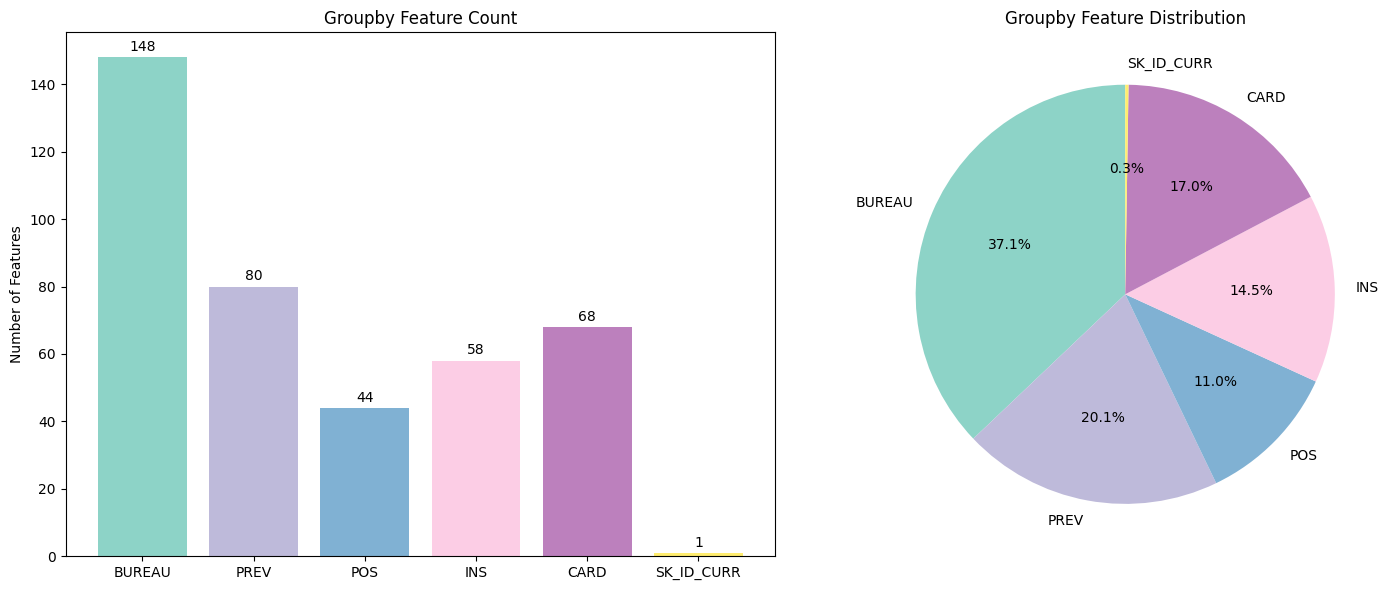

=== Aggregated Feature Summary ===
BUREAU      : 148 features ( 37.1%)
PREV        :  80 features ( 20.1%)
POS         :  44 features ( 11.0%)
INS         :  58 features ( 14.5%)
CARD        :  68 features ( 17.0%)
SK_ID_CURR  :   1 features (  0.3%)
TOTAL       : 399 features


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


def plot_aggregation_summary(train_df_final):
    # Visualize a summary of aggregated feature blocks by data source

    #Count features by source prefix
    feature_counts = {
        'BUREAU': len([col for col in train_df_final.columns if col.startswith('BUREAU_')]),
        'PREV': len([col for col in train_df_final.columns if col.startswith('PREV_')]),
        'POS': len([col for col in train_df_final.columns if col.startswith('POS_')]),
        'INS': len([col for col in train_df_final.columns if col.startswith('INS_')]),
        'CARD': len([col for col in train_df_final.columns if col.startswith('CARD_')]),
        'SK_ID_CURR': len([col for col in train_df_final.columns if not any(col.startswith(prefix) for prefix in ['BUREAU_', 'PREV_', 'POS_', 'INS_', 'CARD_']) and col != 'TARGET'])
    }
    
    # Plot: bar (counts) + pie (share)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    sources = list(feature_counts.keys())
    counts = list(feature_counts.values())
    colors = plt.cm.Set3(np.linspace(0, 1, len(sources)))
    
    bars = ax1.bar(sources, counts, color=colors)
    ax1.set_title('Groupby Feature Count')
    ax1.set_ylabel('Number of Features')
    ax1.tick_params(axis='x')
    
    for bar, count in zip(bars, counts):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                str(count), ha='center', va='bottom')

    ax2.pie(counts, labels=sources, autopct='%1.1f%%', colors=colors, startangle=90)
    ax2.set_title('Groupby Feature Distribution')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed stats
    print("=== Aggregated Feature Summary ===")
    total_features = sum(counts)
    for source, count in feature_counts.items():
        percentage = (count / total_features) * 100
        print(f"{source:12}: {count:3d} features ({percentage:5.1f}%)")
    print(f"{'TOTAL':12}: {total_features:3d} features")


plot_aggregation_summary(train_df_final)
    

# KDE Visualization for Key Aggregated Features

This section plots **kernel density estimates (KDEs)** for several engineered, aggregated features to compare their distributions between **non-defaulted** customers (`TARGET = 0`) and **defaulted** customers (`TARGET = 1`).


- **Selects key features** (e.g., historical refusal ratio, recent remaining instalments, mild DPD rate, recent card utilization).
- **Validates inputs**: skips missing, constant, or too-sparse features to avoid misleading graphs.
- **Draws paired KDE curves** per feature: one curve for `TARGET = 0`, one for `TARGET = 1`.
- **Arranges results** in a 2×2 grid for quick side-by-side comparison.




## Typical insights
- **PREV_REFUSED_RATIO**: Higher refusal history tends to align with higher default risk.
- **POS_M24 remaining instalments**: More remaining periods can indicate heavier short-term repayment burden.
- **INS mild-DPD rate**: Frequent mild delays often correlate with future default.
- **CARD 3-month utilization max**: Recent high utilization may reflect liquidity stress.


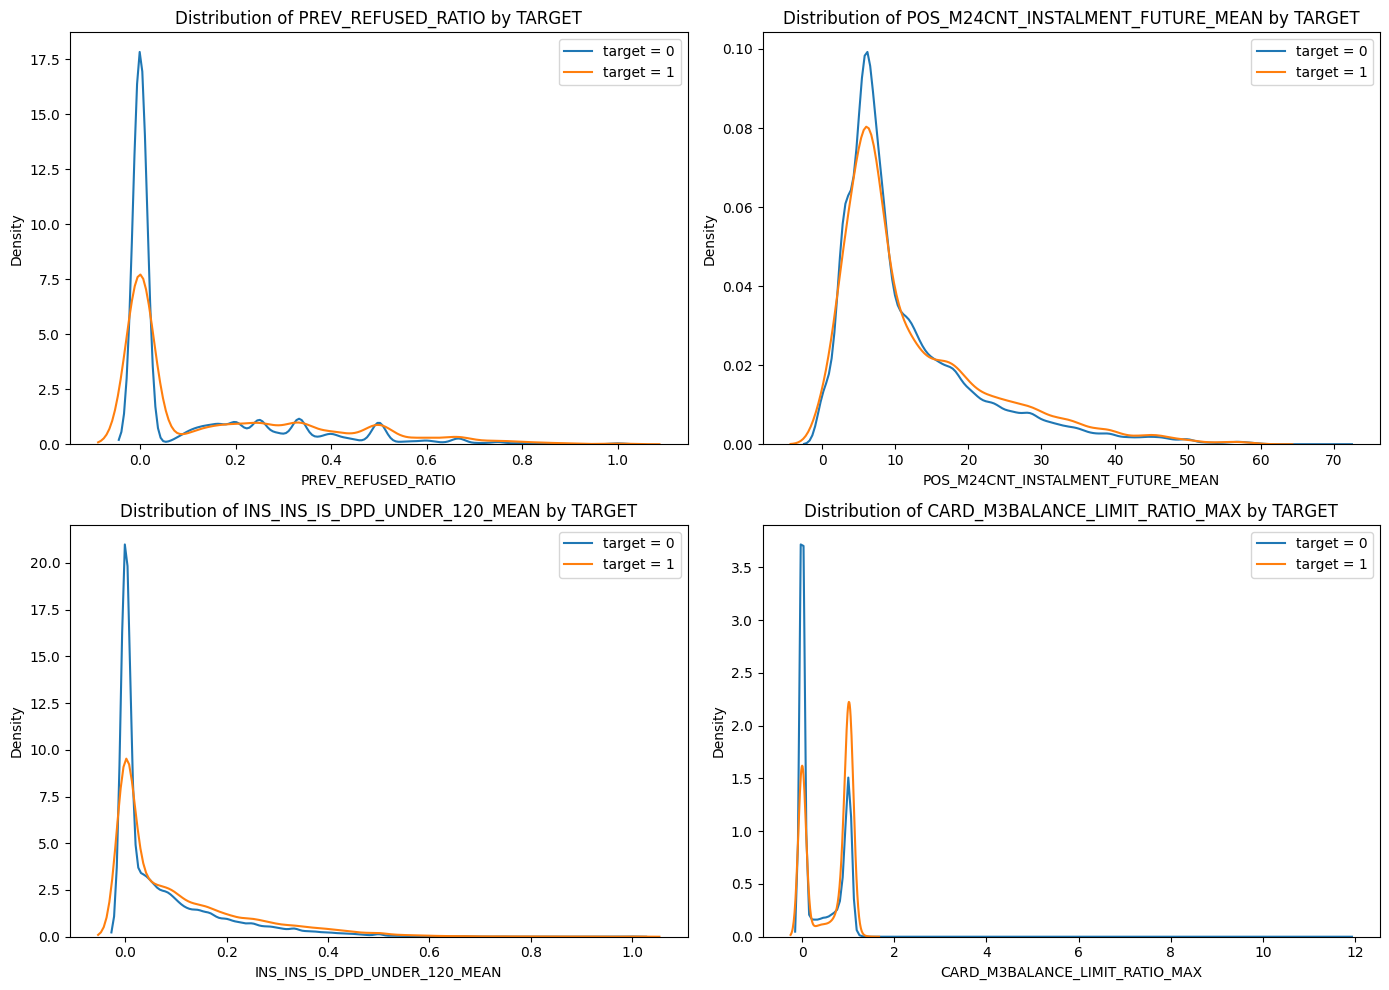

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

features = [
    ('PREV_REFUSED_RATIO', 'Distribution of PREV_REFUSED_RATIO by TARGET'),
    ('POS_M24CNT_INSTALMENT_FUTURE_MEAN', 'Distribution of POS_M24CNT_INSTALMENT_FUTURE_MEAN by TARGET'),
    ('INS_INS_IS_DPD_UNDER_120_MEAN', 'Distribution of INS_INS_IS_DPD_UNDER_120_MEAN by TARGET'),
    ('CARD_M3BALANCE_LIMIT_RATIO_MAX', 'Distribution of CARD_M3BALANCE_LIMIT_RATIO_MAX by TARGET'),
]

plt.figure(figsize=(14, 10))

for i, (col, title) in enumerate(features, 1):
    # Skip columns that are missing
    if col not in train_df_final.columns:
        print(f"[WARN] Column not found: {col} — skipped")
        continue
    data = train_df_final[['TARGET', col]].dropna()

    # Skip if the column is (almost) constant or too few valid samples
    if data[col].nunique() <= 1 or data.shape[0] < 10:
        print(f"[WARN] Column {col} has too few unique/valid values — skipped")
        continue

    plt.subplot(2, 2, i)
    # Plot class-wise KDE curves
    sns.kdeplot(data=data[data['TARGET'] == 0][col], label='target = 0', fill=False)
    sns.kdeplot(data=data[data['TARGET'] == 1][col], label='target = 1', fill=False)

    plt.title(title)
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.legend()

plt.tight_layout()
plt.show()
